In [1]:
import sys
sys.path.append('../')
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from os import remove
from pprint import pprint
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,10]
from base_learners import cnn,lstm,gru

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_data_from_file(filename):
    with open(filename,'r', errors='ignore') as fin:
        lines = fin.readlines()
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [3]:
train_labels,train_sentences = load_data_from_file('dataset/sst1/stsa.fine.train')
dev_label,dev_sentence = load_data_from_file('dataset/sst1/stsa.fine.dev')

In [4]:
train_sentences = train_sentences+dev_sentence
train_labels = train_labels+dev_label

In [5]:
len(train_labels),len(train_sentences)

(9645, 9645)

In [6]:
number_of_classes = len(set(train_labels))
number_of_classes

5

In [7]:
for x in range(number_of_classes):
    print(x,train_labels.count(x))

0 1231
1 2507
2 1853
3 2601
4 1453


In [8]:
def remove_punctuation(s):
    list_punctuation = list(string.punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s

In [9]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    # should have used translate but for some reason it breaks on my server
    tokens = [remove_punctuation(w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [10]:
print("cleaning train data")
trainX = np.array([clean_sentence(s) for s in train_sentences])
trainY = np.array(train_labels)

cleaning train data


In [11]:
back_up_for_fasttext = trainX

In [12]:
lengths = [len(line.split()) for line in trainX]

30


(array([ 503., 1766., 2173., 2127., 1592.,  883.,  415.,  156.,   22.,
           8.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

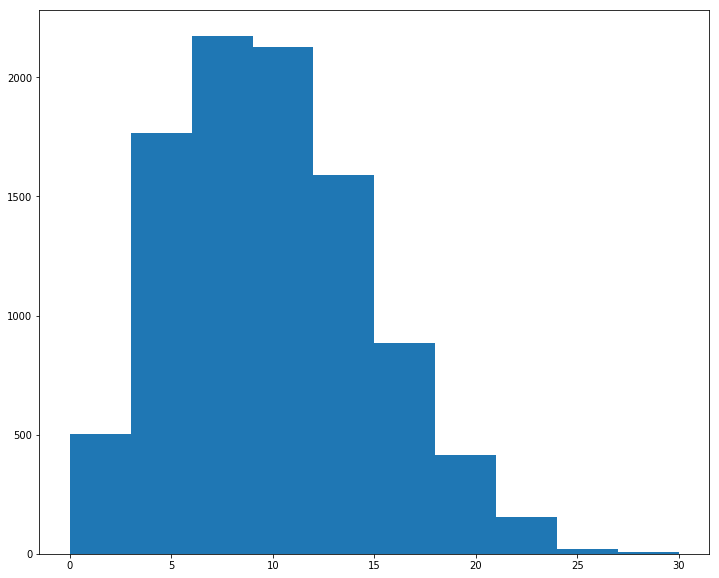

In [13]:
print(max(lengths))
plt.hist(lengths)

In [14]:
max_len = 24

In [15]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [17]:
def load_GloVe_embedding(file_name):
    print('Loading GloVe word vectors.')
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [18]:
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [19]:
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m


In [20]:
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [21]:
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [22]:
def get_word_embedding_matrix(model,dim):
    #dim = 300 for google word2vec
    #dim = 400 for godin
    #dim = 100 for fast text
    embedding_matrix = np.zeros((vocab_size,dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [23]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)
trainY = to_categorical(trainY,num_classes=number_of_classes)

Max document length: 24
Vocabulary size: 17103


In [24]:
# glove_model = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
# fast_text_model = load_fast_text_model(back_up_for_fasttext)
# godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('../word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [25]:
# embedding_matrix_glove = get_GloVe_embedding_matrix(glove_model)
embedding_matrix_word2vec = get_word_embedding_matrix(word2vec_model,300)
# embedding_matrix_fast_text = get_word_embedding_matrix(fast_text_model,100)
# embedding_matrix_godin = get_word_embedding_matrix(godin_model,400)

In [26]:
parameters_cnn = {
            "n_dense": 250,
            "dropout": 0.2,
            "learning_rate": 0.001,
            "n_filters": 100,
            "filter_size": 5,
            "em": embedding_matrix_word2vec,
            "em_trainable_flag":True,
            "batch": 32,
            "epoch": 5
        }

In [27]:
parameters_lstm_or_gru = {
            "dropout": 0.2,
            "learning_rate": 0.001,
            "units_out": 128,
            "em": embedding_matrix_word2vec,
            "em_trainable_flag":True,
            "batch": 32,
            "epoch": 15
        }

In [28]:
# model = cnn(length=max_len,
#             vocab_size=vocab_size,
#             n_dense=parameters_cnn['n_dense'],
#             dropout=parameters_cnn['dropout'],
#             learning_rate=parameters_cnn['learning_rate'],
#             n_filters=parameters_cnn['n_filters'],
#             filter_size=parameters_cnn['filter_size'],
#             em = parameters_cnn['em'],
#             free_em_dim=parameters_cnn['free_em_dim'],
#             number_of_classes=number_of_classes,
#             em_trainable_flag=parameters_cnn['em_trainable_flag'])

In [29]:
model = gru(length=max_len,
             vocab_size=vocab_size,
             learning_rate=parameters_lstm_or_gru['learning_rate'],
             dropout=parameters_lstm_or_gru['dropout'],
             units_out=parameters_lstm_or_gru['units_out'],
             em=parameters_lstm_or_gru['em'],
             number_of_classes=number_of_classes,
             em_trainable_flag=parameters_lstm_or_gru['em_trainable_flag'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 300)           5130900   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               164736    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 5,296,281
Trainable params: 5,296,281
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(trainX,trainY,epochs=parameters_lstm_or_gru["epoch"],batch_size=parameters_lstm_or_gru["batch"])

Epoch 1/15
9645/9645 [==============================] - 33s 3ms/step - loss: 0.4882 - acc: 0.7997
Epoch 2/15
9645/9645 [==============================] - 33s 3ms/step - loss: 0.4281 - acc: 0.8011
Epoch 3/15
9645/9645 [==============================] - 37s 4ms/step - loss: 0.3596 - acc: 0.8287
Epoch 4/15
9645/9645 [==============================] - 32s 3ms/step - loss: 0.2857 - acc: 0.8731
Epoch 5/15
9645/9645 [==============================] - 33s 3ms/step - loss: 0.2162 - acc: 0.9109
Epoch 6/15
9645/9645 [==============================] - 33s 3ms/step - loss: 0.1459 - acc: 0.9440
Epoch 7/15
9645/9645 [==============================] - 31s 3ms/step - loss: 0.0959 - acc: 0.9645
Epoch 8/15
9645/9645 [==============================] - 31s 3ms/step - loss: 0.0680 - acc: 0.9759
Epoch 9/15
9645/9645 [==============================] - 31s 3ms/step - loss: 0.0483 - acc: 0.9835
Epoch 10/15
9645/9645 [==============================] - 31s 3ms/step - loss: 0.0377 - acc: 0.9869
Epoch 11/15
9645/96

In [32]:
test_labels,test_sentences = load_data_from_file('dataset/sst1/stsa.fine.test')

In [33]:
len(test_labels),len(test_sentences)

(2210, 2210)

In [34]:
for x in range(number_of_classes):
    print(x,test_labels.count(x))

0 279
1 633
2 389
3 510
4 399


In [35]:
testX = [clean_sentence(s) for s in test_sentences]

In [36]:
testX = encode_text(tokenizer, testX, max_len)

In [37]:
pred = model.predict(testX)

In [38]:
pred_class = [np.argmax(x) for x in pred]

In [39]:
pred_class

[1,
 1,
 1,
 0,
 2,
 2,
 4,
 4,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 3,
 0,
 0,
 3,
 2,
 4,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 1,
 1,
 2,
 1,
 2,
 3,
 1,
 3,
 4,
 4,
 3,
 3,
 2,
 4,
 3,
 0,
 3,
 3,
 0,
 1,
 2,
 0,
 2,
 3,
 4,
 2,
 2,
 2,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 2,
 3,
 1,
 2,
 4,
 1,
 1,
 4,
 3,
 3,
 2,
 3,
 1,
 1,
 1,
 3,
 1,
 2,
 0,
 2,
 3,
 2,
 3,
 1,
 3,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 2,
 3,
 1,
 3,
 3,
 1,
 1,
 4,
 2,
 4,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 4,
 3,
 3,
 3,
 2,
 4,
 2,
 1,
 4,
 3,
 3,
 2,
 0,
 1,
 4,
 3,
 2,
 2,
 1,
 3,
 0,
 2,
 4,
 4,
 2,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 3,
 2,
 4,
 2,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 0,
 1,
 0,
 2,
 4,
 1,
 4,
 3,
 1,
 2,
 4,
 4,
 3,
 0,
 3,
 2,
 4,
 2,
 1,
 4,
 0,
 4,
 2,
 2,
 2,
 3,
 4,
 0,
 2,
 3,
 2,
 4,
 1,
 3,
 3,
 1,
 4,
 3,
 1,
 3,
 2,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 4,
 0,
 2,
 2,
 3,
 1,
 1,
 1,
 4,
 3,
 2,
 2,
 1,
 3,
 4,
 3,
 4,
 3,
 2,
 1,


In [40]:
acc = accuracy_score(test_labels,pred_class)

In [41]:
acc

0.38099547511312215